In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
import csv

from pprint import pprint
from datetime import datetime

import umap

In [2]:
from typenet_training import *

Train size: (67000,)
Validation size: (1000,)
Test size: (100183,)
((5, 7), (5, 25), (45158, 494132))
((5, 10), (5, 33), (84976, 928094))
((5, 15), (5, 10), (91862, 1004056))
((5, 21), (5, 39), (129095, 1402473))
((5, 25), (5, 60), (23573, 253709))
((5, 29), (5, 21), (3508, 37165))
((5, 33), (5, 39), (118100, 1282520))
((5, 39), (5, 21), (76906, 838513))
((5, 43), (5, 39), (39263, 426666))
((5, 48), (5, 25), (134871, 1467793))
((5, 52), (5, 7), (82910, 905991))
((5, 60), (5, 33), (138441, 1503652))
((5, 71), (5, 10), (86210, 942683))
((5, 73), (5, 15), (97285, 1063650))
((5, 83), (5, 10), (174147, 1892284))
((7, 11), (7, 97), (60821, 668008))
((7, 24), (7, 85), (26068, 278857))
((7, 35), (7, 114), (74659, 813864))
((7, 42), (7, 187), (127913, 1390545))
((7, 50), (7, 126), (158147, 1719346))
Model: "embedding_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 50, 5) 

In [3]:
siamese_model.load_weights('trained/checkpoint-46-0.600')

In [4]:
class GalleryIdSequence(tf.keras.utils.Sequence):

    def __init__(self, participant_ids, enrollment_sequences_per_subject):
        self.enrollment_sequences_per_subject = enrollment_sequences_per_subject
        self.participant_ids = participant_ids
        self.mapping = np.repeat(
            np.arange(len(self.participant_ids)), self.enrollment_sequences_per_subject)

    def __len__(self):
        return math.ceil(len(self.participant_ids)*enrollment_sequences_per_subject)

    def __getitem__(self, index):
        anchor_id = self.participant_ids[self.mapping[index]]
        anchor_sections = parsed_sections.loc[anchor_id]
        anchor_section = anchor_sections[index %
                                         self.enrollment_sequences_per_subject]

        return (anchor_id, anchor_section)

class GallerySequence(tf.keras.utils.Sequence):

    def __init__(self, batch_size, participant_ids, enrollment_sequences_per_subject):
        self.batch_size = batch_size
        self.participant_ids = participant_ids
        self.indices = GalleryIdSequence(
            participant_ids, enrollment_sequences_per_subject)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, generator_idx):
        (anchor_id, anchor_section_id) = self.indices[generator_idx]
        try:
            cols = ['KEYCODE', 'HL', 'IL', 'PL', 'RL']
            anchor_features = pd.read_feather(
                f'{input_dir}/{anchor_id}/{anchor_id}_section_{anchor_section_id}_keystrokes.feather', columns=cols)

            padded_anchor_features = zero_pad_rows(
                anchor_features, number_of_keystrokes_per_seq).values
            
            return np.expand_dims(np.array(padded_anchor_features), axis=0)

        except Exception as e:
            print(e)
            traceback.print_exc()

In [5]:
# to show a trend they scale it up and down in the paper
test_subjects_k = 1000

# G = 2 for one-shot authentication. 
# G = 1 for no genuine scores (identification). 
# Never G > 10 in the paper
G = 5

In [6]:
gallery_seq = GallerySequence(batch_size, test_participants, enrollment_sequences_per_subject=G)

In [7]:
# Make sure the gallery sequence is working as expected
assert (gallery_seq[2] == gallery_seq[1]).all() == False
assert (gallery_seq[1] == gallery_seq[1]).all() == True

In [8]:
test_scores_to_retrieve = G * test_subjects_k

In [9]:
# get the layer outputs from the embedding layer in the siamese network
embedding_layer = siamese_model.siamese_network.get_layer('embedding_rnn')

test_gallery_embeddings = np.array([embedding_layer(gallery_seq[x]) for x in range(0, test_scores_to_retrieve)])
test_gallery_embeddings = test_gallery_embeddings.reshape(test_scores_to_retrieve, 128)

In [10]:
embedding_labels = [gallery_seq.indices[x][0] for x in range(0, test_scores_to_retrieve)]

In [11]:
test_gallery_embeddings.shape

(5000, 128)

# Validation as authentication system

In [12]:
from sklearn.metrics.pairwise import pairwise_distances

dist_matrix = pairwise_distances(test_gallery_embeddings, metric='euclidean')
dist_matrix.shape

(5000, 5000)

In [13]:
# mask impostor as 0 and genuine as 1

def get_impostor_genuine_mask_from_pairwise_matrix(pairwise_matrix, embedding_labels):
    mask = np.zeros_like(pairwise_matrix)
    for i in range(len(embedding_labels)):
        for j in range(len(embedding_labels)):
            if embedding_labels[i] == embedding_labels[j]:
                mask[i][j] = 1
    
    # return upper/lower part of the matrix without the diagonal, flatten as a 1D list and
    # return as bool (so it can be applied to a pandas dataframe)
    lower_indices = np.triu_indices(len(embedding_labels), k=1)
    return mask[lower_indices].flatten().astype(bool)

In [14]:
def distance_matrix_to_normalised_similarity_matrix_and_mask(distance_matrix):
    mask = get_impostor_genuine_mask_from_pairwise_matrix(distance_matrix, embedding_labels)

    # take upper triangle of distance matrix without the diagonal
    distance_matrix = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

    scores = distance_matrix.flatten()

    scores = (scores - scores.min())/(scores.max()-scores.min())

    # invert scores to get a similarity measure (and not distance)
    scores = 1 - scores

    return(mask, scores)

In [15]:
genuine_impostor_mask, scores = distance_matrix_to_normalised_similarity_matrix_and_mask(dist_matrix)

In [16]:
scores = pd.DataFrame(data=scores, columns=['score'])
scores.loc[genuine_impostor_mask, 'identity'] = 'genuine'
scores.loc[~genuine_impostor_mask, 'identity'] = 'impostor'

scores

,score,identity
0,0.744022,genuine
1,0.758986,genuine
2,0.810538,genuine
3,0.761446,genuine
4,0.328566,impostor
...,...,...
12497495,0.739845,genuine
12497496,0.592648,genuine
12497497,0.799135,genuine
12497498,0.632169,genuine


In [17]:
scores['identity'].value_counts()

impostor    12487500
genuine        10000
Name: identity, dtype: int64

In [18]:
# pairwise genuine shape assertion
assert G*(G-1)/2*test_subjects_k == scores['identity'].value_counts()['genuine']

Text(0.5, 1.0, 'Genuine and impostor scores')

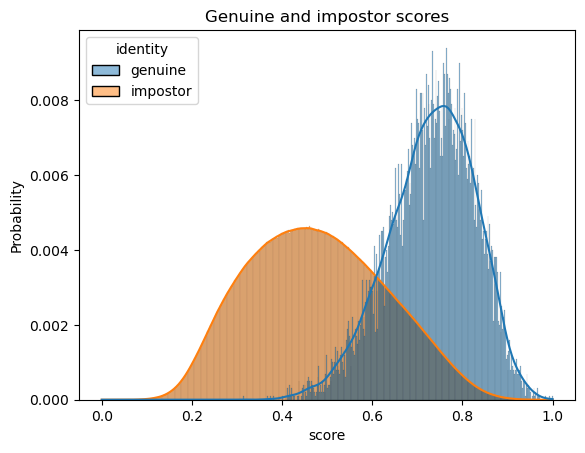

In [33]:
hist = sns.histplot(scores, hue='identity', x='score', stat='probability', kde=True, alpha=0.5, common_norm=False)
hist.set_title(f'Genuine and impostor scores')

(0.6326530612244897, 15.6)

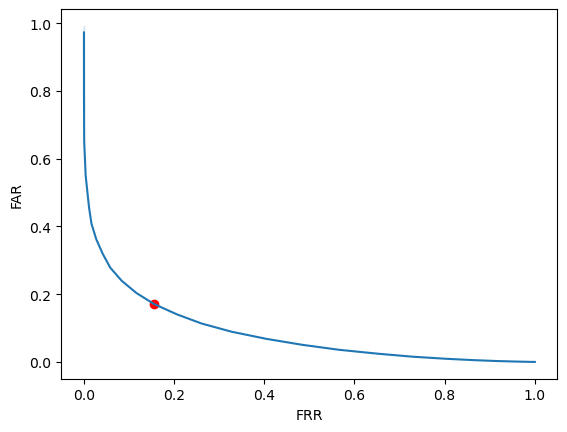

In [21]:
from sklearn.metrics import confusion_matrix

def fpr_tpr_scores(threshold, scores, y_true):
    y_pred = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fn)
    return false_positive_rate, true_positive_rate

def eer_threshold(scores, y_true):
    thresholds = np.linspace(0, 1, 50)
    fpr = [fpr_tpr_scores(threshold, scores, y_true)[0] for threshold in thresholds]
    frr = [1 - (fpr_tpr_scores(threshold, scores, y_true)[1]) for threshold in thresholds]

    abs_diff = np.abs(np.array(fpr) - np.array(frr))

    ith_threshold = np.argmin(abs_diff)

    p = sns.lineplot(x=frr, y=fpr)
    p.scatter(x=frr[ith_threshold], y=fpr[ith_threshold], color='r')
    p.set_xlabel('FRR')
    p.set_ylabel('FAR')

    # return threshold and EER %
    return thresholds[ith_threshold], round(frr[ith_threshold]*100,2)

eer_threshold(scores['score'], pd.get_dummies(scores['identity'])['genuine'])

In [22]:
scores.pivot_table(index='identity', values='score', aggfunc=['mean', 'std'])

,mean,std
,score,score
identity,,
genuine,0.731432,0.095680
impostor,0.477757,0.150138


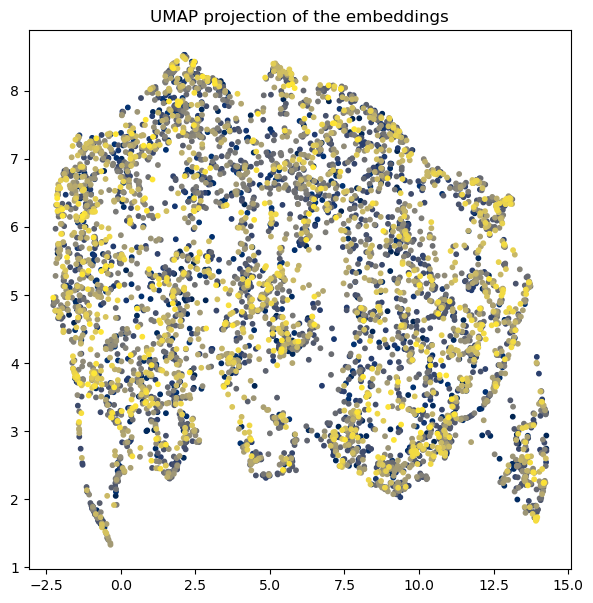

In [32]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_gallery_embeddings)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(embedding[:, 0], embedding[:, 1], c=embedding_labels, cmap='cividis', s=10)
ax.set_title('UMAP projection of the embeddings')
plt.show()

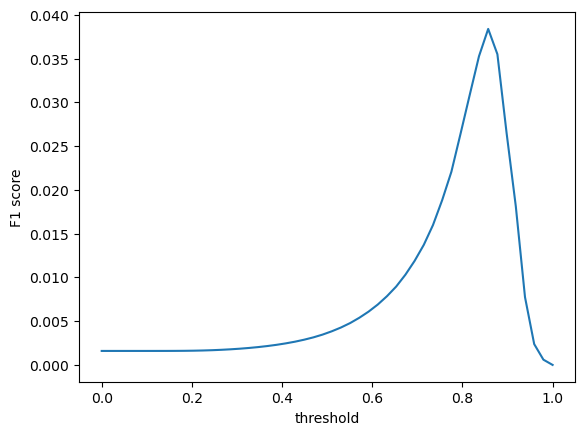

In [24]:
from sklearn.metrics import f1_score

def f1_score_threshold(scores, y_true):
    thresholds = np.linspace(0, 1, 50)
    f1 = [f1_score(y_true, scores > threshold) for threshold in thresholds]
    p = sns.lineplot(x=thresholds, y=f1)
    p.set_xlabel('threshold')
    p.set_ylabel('F1 score')

f1_score_threshold(scores['score'], pd.get_dummies(scores['identity'])['genuine'])

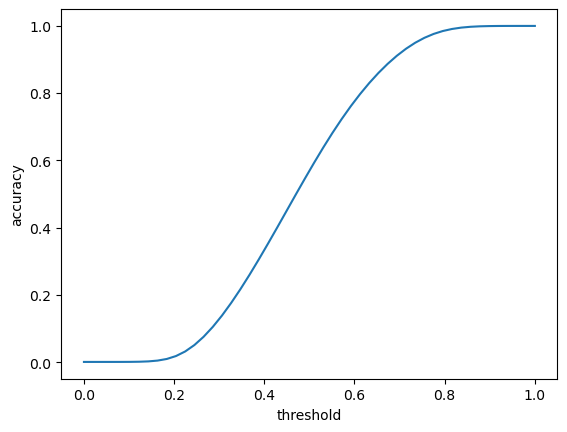

In [25]:
def accuracy_score_threshold(scores, y_true):
    thresholds = np.linspace(0, 1, 50)
    accuracy = [accuracy_score(y_true, scores > threshold) for threshold in thresholds]
    p = sns.lineplot(x=thresholds, y=accuracy)
    p.set_xlabel('threshold')
    p.set_ylabel('accuracy')

accuracy_score_threshold(scores['score'], pd.get_dummies(scores['identity'])['genuine'])

# Validation as identification system

In [26]:
# average all genuine scores together so we get a single score for each user.
def aggregate_dist_matrix(dist_matrix, targets):
    # create a dataframe from the distance matrix
    df = pd.DataFrame(data=dist_matrix, index=targets, columns=targets)

    # set NaN to the diagonal of df so they are dropped when taking the mean
    df = df.mask(np.eye(df.shape[0], dtype=bool))

    # aggregate the values by taking the minimum
    df = df.groupby(level=0, axis=0).mean()
    df = df.groupby(level=0, axis=1).mean()

    return df

In [27]:
agg_dist_matrix = aggregate_dist_matrix(dist_matrix, embedding_labels)
agg_dist_matrix

,204336,204339,204340,204349,204361,204368,204369,204373,204375,204376,...,207823,207828,207835,207842,207844,207846,207848,207850,207851,207872
204336,1.942885,5.047910,4.185449,2.716285,2.327973,4.908590,3.731440,2.112233,3.409091,3.832870,...,4.914910,2.444638,2.793398,4.314673,2.418587,5.211877,5.057224,3.149246,4.402306,5.166123
204339,5.047910,2.272020,3.456442,5.031982,4.990925,4.228139,5.829305,5.057009,4.438115,4.060984,...,2.565176,5.320334,5.157827,3.355745,5.114223,2.293004,2.860008,4.571562,3.392753,2.708726
204340,4.185449,3.456442,1.541105,4.226632,4.057528,3.600747,5.353595,4.082217,3.560527,2.679640,...,3.061739,4.549834,4.375815,2.231768,4.145201,3.867625,3.353444,3.634718,2.796848,3.325367
204349,2.716285,5.031982,4.226632,1.674117,2.537722,5.277033,4.510421,3.244291,2.819793,3.993544,...,4.817937,3.773756,3.946873,4.089160,3.332696,5.058095,4.900284,2.270150,3.867759,5.341807
204361,2.327973,4.990925,4.057528,2.537722,2.525913,4.931666,4.051748,2.609741,3.220538,3.758024,...,4.764640,3.085185,3.175261,4.168902,2.748841,5.116050,4.901273,2.939952,4.187854,5.088006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207846,5.211876,2.293004,3.867626,5.058095,5.116051,4.707824,6.074961,5.276677,4.510017,4.468149,...,2.735066,5.567065,5.397269,3.623057,5.338451,1.851207,2.974356,4.610207,3.385200,3.176168
207848,5.057224,2.860008,3.353444,4.900284,4.901273,4.103495,5.633782,4.990250,4.179109,3.930455,...,2.224540,5.436368,5.068989,3.240353,5.044301,2.974356,2.510515,4.464620,3.133470,3.084724
207850,3.149246,4.571562,3.634718,2.270150,2.939952,5.000009,4.941429,3.585883,2.378260,3.790311,...,4.386954,4.098671,4.275174,3.433004,3.682852,4.610207,4.464620,2.195028,3.188950,4.982017
207851,4.402306,3.392753,2.796847,3.867759,4.187854,4.499263,5.760333,4.636090,3.196925,3.755840,...,2.948985,5.070871,5.083217,2.392589,4.668283,3.385200,3.133470,3.188950,1.600109,3.934098


(<AxesSubplot: title={'center': 'Cumulative Matching Curve - TypeNet'}, xlabel='Rank (t)', ylabel='Rank-t identification rate (%)'>,
 16.0)

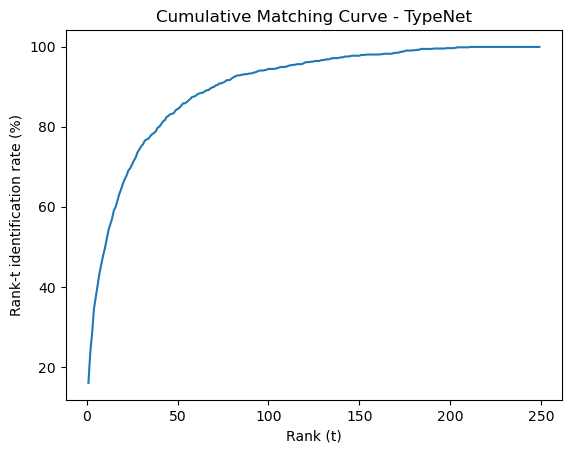

In [31]:
def cmc_curve(similarity_matrix, n_total_samples, label, rank_range=range(1, 100)):
    t_counts = []
    t_cumulative_cnt = 0

    for t in rank_range:
        for index, row in similarity_matrix.iterrows():
            sorted_row = row.sort_values(ascending=True)
            row_rank = sorted_row.index.get_loc(index) + 1

            if t == row_rank:
                t_cumulative_cnt += 1
        
        t_counts.append(t_cumulative_cnt / n_total_samples)
    
    t_counts = np.array(t_counts) * 100
    
    p = sns.lineplot(x=rank_range, y=t_counts)
    p.set_xlabel('Rank (t)')
    p.set_ylabel('Rank-t identification rate (%)')
    p.set_title(label)

    rank1 = t_counts[0]

    return p, rank1

cmc_curve(agg_dist_matrix, agg_dist_matrix.shape[0], f'Cumulative Matching Curve - TypeNet', range(1, 250))